In [1]:
import numpy as np
import matplotlib.pyplot as plt
# import pandas_datareader as web
import math
import yfinance as yf
import pandas as pd
import seaborn as sns

In [2]:
from keras import Input
from keras import layers
from tensorflow.keras.optimizers import RMSprop
import random

In [3]:
import sys
sys.path.append('../..')

#import ep.etools as apt

In [4]:
import warnings
warnings.filterwarnings( "ignore", module = "matplotlib\..*" )
from tqdm import tqdm

In [139]:
dataCalendar = pd.read_csv('./data/bloc_ttf_calendar_prices.csv')
dataPrices = pd.read_csv('./data/bloc_ttf_prices.csv')
dataPrices[' '] = pd.to_datetime(dataPrices[' '])
dataPrices = dataPrices.set_index(' ')


In [140]:
dataPrices['moy20'] = dataPrices['Day-ahead'].rolling(20).mean()

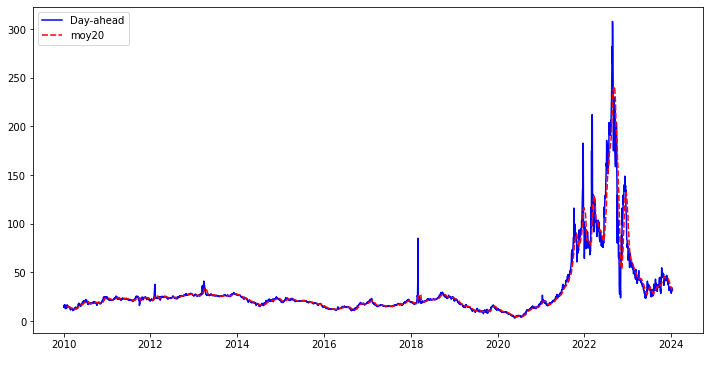

In [141]:
fig, ax = plt.subplots(figsize=(12,6))
sns.lineplot(dataPrices[['Day-ahead','moy20']][0:-1], color='Blue'); #3390
#ax2 = plt.twinx()
#sns.lineplot(data=final['€/$'], ax=ax2 , color='grey')

In [142]:
def getDelta(x,up):
    d = (x.iloc[1]-x.iloc[0])/x.iloc[0]
    if ((d>=0) & (up)):
        return d
    if ((d<0)  & (not up)):
        return d
    return 0

         Day-ahead  Month-ahead  Quarter-ahead   Summer 24   Winter 24  \
count  3662.000000  3589.000000    2568.000000  650.000000  572.000000   
mean     29.965183    30.930758      35.135822   53.214646   58.340210   
std      32.335071    34.205077      41.192667   27.913017   24.531331   
min       3.110000     3.530000       4.710000   15.960000   22.890000   
25%      16.390000    16.320000      16.015000   32.287500   44.857500   
50%      21.550000    21.720000      19.885000   49.950000   54.215000   
75%      26.367500    26.490000      30.987500   60.822500   63.392500   
max     307.850000   319.360000     344.320000  177.160000  171.080000   

        Year-Ahead  2 Year-Ahead        moy20        delta          abs  \
count  3088.000000   3053.000000  3643.000000  3661.000000  3661.000000   
mean     31.853475     27.481271    30.001242     0.185359     3.094583   
std      31.338667     20.343578    31.572644     6.029597     5.177967   
min      11.790000     13.310000 

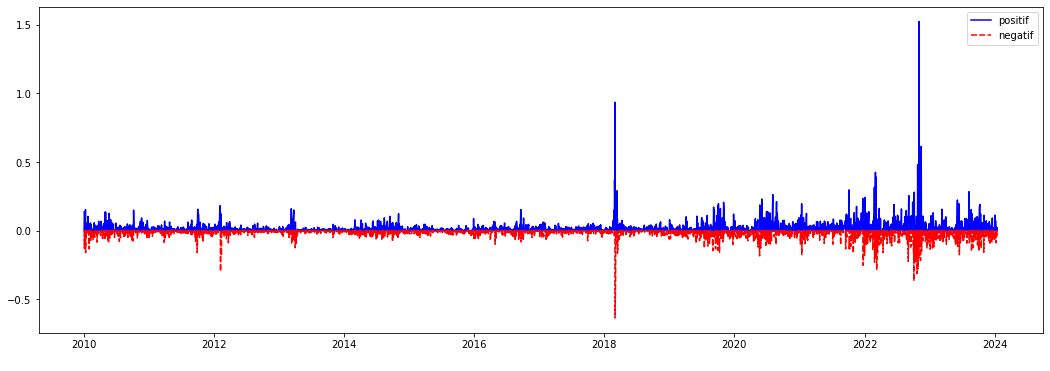

In [143]:
#Variation en %
dataPrices['delta'] =dataPrices['Day-ahead'].rolling(2).apply(lambda x: (x.iloc[1] - x.iloc[0])/x.iloc[0]*100)
dataPrices['abs'] =dataPrices['Day-ahead'].rolling(2).apply(lambda x: abs(x.iloc[1] - x.iloc[0])/x.iloc[0]*100)
dataPrices['positif'] =dataPrices['Day-ahead'].rolling(2).apply(lambda x: getDelta(x,True))
dataPrices['negatif'] =dataPrices['Day-ahead'].rolling(2).apply(lambda x: getDelta(x,False))
fig, ax = plt.subplots(figsize=(18,6))
sns.color_palette("rocket")
sns.set_palette(['Blue','Red'])
sns.lineplot(dataPrices[['positif','negatif']])
print(dataPrices.describe())


In [144]:
std = dataPrices['abs'].std()
max = dataPrices['positif'].max()
min = dataPrices['negatif'].min()
inc = std/10.
print(std,max,min)

5.1779673089223905 1.5231286795626575 -0.6361176470588236


In [149]:
def CountVal(arr,min,max):
    c = 0
    for v in arr:
        if ( (v>=min) & (v<=max)):
            c += 1
    return c

1768


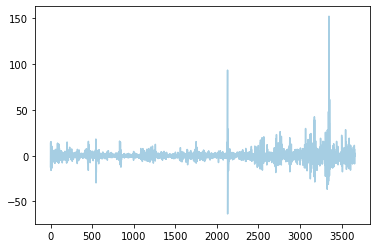

In [296]:
print(CountVal(values,0,10.0))
sns.lineplot(values);

-63.611765     1
-63.511765     0
-63.411765     0
-63.311765     0
-63.211765     0
              ..
 151.888235    0
 151.988235    0
 152.088235    0
 152.188235    0
 152.288235    1
Name: val, Length: 2160, dtype: int64


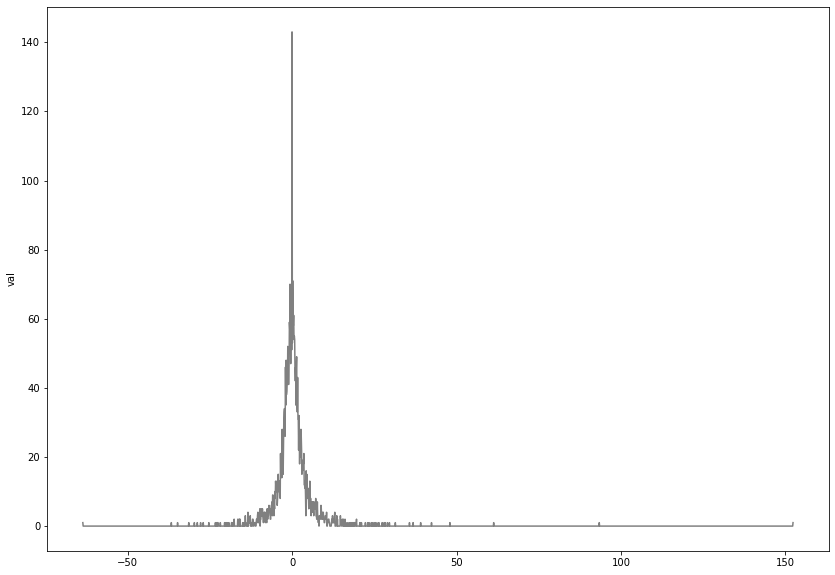

In [298]:
#Les positifs
# create intervals
values = dataPrices['delta'].values[1:-1] #3390
bins = np.arange(values.min(),values.max(),0.1)
counts = np.histogram(values,bins=bins) #bins='auto')
counts = (np.insert(counts[0], counts[0].size, 1.0), counts[1])
# create a Series, indexed by interval midpoints and convert to dictionary
pdS = pd.Series(counts[0], index=counts[1]).to_frame()   #.to_dict()
pdS['freq'] = pdS.index.values
fig, ax = plt.subplots(figsize=(14,10))
# plt.yscale('log')
# plt.xscale('log')
pdS = pdS.rename(columns={0:'val'})
# pdS.sort_values('val',inplace=True,ascending=False)
# sns.lineplot(counts, color='Grey');
sns.lineplot(pdS['val'], color='Grey');
# print(pdS.describe())
print(pdS['val'])
# print(counts[1].size)

             val       freq
count  14.000000  14.000000
mean    3.714286   0.751000
std     2.163636   0.448211
min     0.000000   0.054571
25%     2.250000   0.402786
50%     4.000000   0.751000
75%     4.750000   1.099214
max     7.000000   1.447429
0.054571    7
0.161714    7
0.268857    6
0.376000    5
0.483143    4
0.590286    4
0.697429    4
0.804571    4
0.911714    4
1.018857    3
1.126000    2
1.233143    1
1.340286    1
1.447429    0
Name: val, dtype: int64


/Users/rky/miniforge3/envs/tf-M1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


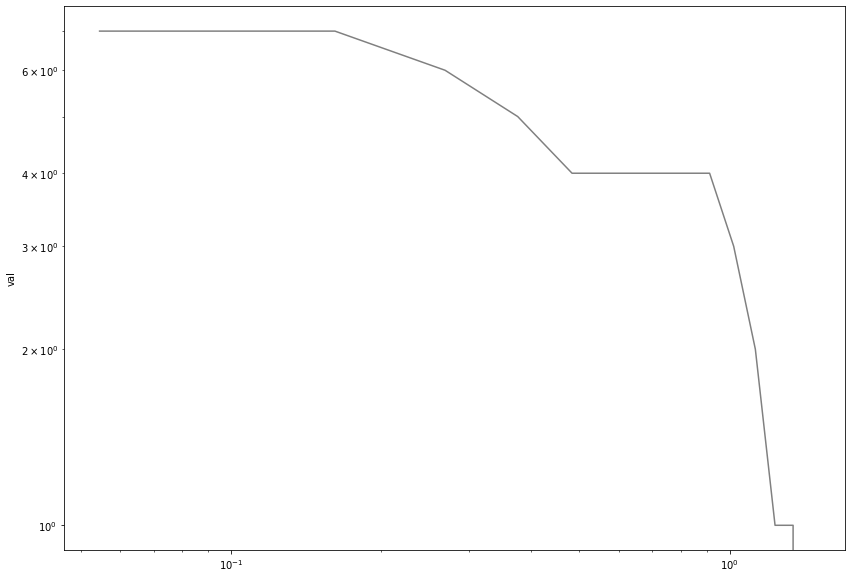

In [136]:
#df= dataPrices['delta'].value_counts(bins=100)
# create intervals
dataPrices = dataPrices[3390:]
bins = pd.interval_range(0.001, max, freq=0.1)
# assign each value in df["column"] to bin and count bin occurences
counts = pd.cut(dataPrices['abs'], bins).value_counts()
# print(counts.info)
# create a Series, indexed by interval midpoints and convert to dictionary
pdS = pd.Series(counts.values, index=bins.mid).to_frame()   #.to_dict()
pdS['freq'] = pdS.index.values
fig, ax = plt.subplots(figsize=(14,10))
plt.yscale('log')
plt.xscale('log')
pdS = pdS.rename(columns={0:'val'})
sns.lineplot(pdS['val'], color='Grey');
print(pdS.describe())
print(pdS['val'])

In [299]:
distribution = pdS
# distribution = distribution.rename(columns={0:'val'})
# distribution['freq'] = (bins.mid)
distribution['cumul'] = distribution['val'].cumsum(skipna=True)
distribution.reset_index(drop=True,inplace=True)
print(distribution.describe())


               val         freq        cumul
count  2160.000000  2160.000000  2160.000000
mean      1.694444    44.338235  2579.792130
std       7.882954    62.368261  1623.584684
min       0.000000   -63.611765     1.000000
25%       0.000000    -9.636765    94.500000
50%       0.000000    44.338235  3656.000000
75%       0.000000    98.313235  3659.000000
max     143.000000   152.288235  3660.000000


            freq  val  cumul
0     -63.611765    1      1
1     -63.511765    0      1
2     -63.411765    0      1
3     -63.311765    0      1
4     -63.211765    0      1
...          ...  ...    ...
2155  151.888235    0   3659
2156  151.988235    0   3659
2157  152.088235    0   3659
2158  152.188235    0   3659
2159  152.288235    1   3660

[2160 rows x 3 columns]


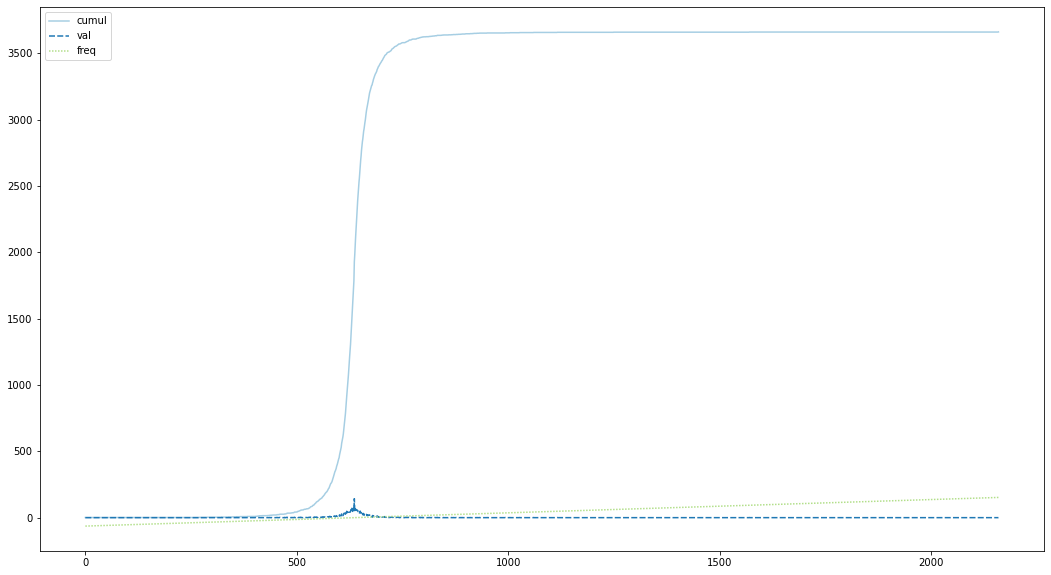

In [319]:
print(distribution[['freq','val','cumul']])
fig=plt.figure(figsize=(18,10))
# plt.yscale('log')
# plt.xscale('log')
sns.lineplot(distribution[['cumul','val','freq']]);

In [320]:
s = distribution['val'].values[0]
m = distribution['val'].sum()
r = random.randint(0,1700)
min = distribution.index[0]
print(r, m, s)
v = distribution['cumul'].loc[lambda x: x>=r].index.min()
print(v)

20 3660 1
444


In [321]:
def sign():
    return 1 if random.random() <0.5 else -1

In [322]:
def getRandomValue(df,crit,val,ref):
    nb = df[val].count()
    max = df[crit].max()
    r = (np.random.uniform(0,max))
    s = sign();
    id = df[crit].loc[lambda x: x>=r].index.min()
    if (id>0):
        v = (df[val][id]-df[val][id-1])*(r-df[crit][id-1])/df[ref][id] + df[val][id-1]
    else:
        v = (df[val][id])*r/df[ref][id]
    return s*v

In [324]:
def getRValue(df,crit,val,ref):
    max = df[crit].max()
    r = (np.random.uniform(0,max))
    id = df[crit].loc[lambda x: x>=r].index.min()
    if (id>0):
        v = (df[val][id]-df[val][id-1])*(r-df[crit][id-1])/df[ref][id] + df[val][id-1]
    else:
        v = (df[val][id])*r/df[ref][id]
    return v    

In [325]:
def getRValueD(df,crit,val,ref):
    max = df[crit].max()
    r = (np.random.uniform(0,max))
    id = df[crit].loc[lambda x: x>=r].index.min()
    # if (id>0):
    #     v = (df[val][id]-df[val][id-1])*(r-df[crit][id-1])/df[ref][id] + df[val][id-1]
    # else:
    v = (df[val][id])
    return v    

In [326]:
getRValue(distribution,'cumul','freq','val')

-2.2321094746821295

100%|██████████| 10000/10000 [00:01<00:00, 8359.72it/s]


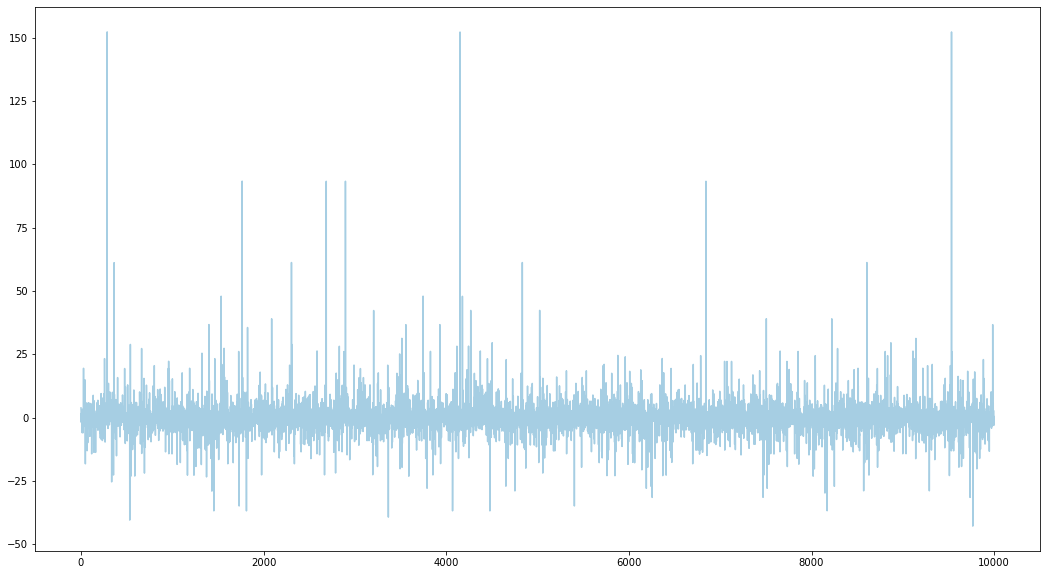

In [332]:
nbEchantillon = 10000
simul = np.ones(nbEchantillon)
for i in tqdm(range(nbEchantillon)):
    simul[i] = (getRValue(distribution,'cumul','freq','val'))
    
fig = plt.figure(figsize=(18,10))
plt.plot(simul);

In [328]:
#distribution.reset_index(drop=True,inplace=True)
#distribution.set_index()
distribution.iloc[55]

val       0.000000
freq    -58.111765
cumul     1.000000
Name: 55, dtype: float64

In [329]:
from pandas.tseries.offsets import DateOffset,BusinessDay

100%|██████████| 100/100 [00:04<00:00, 24.48it/s]


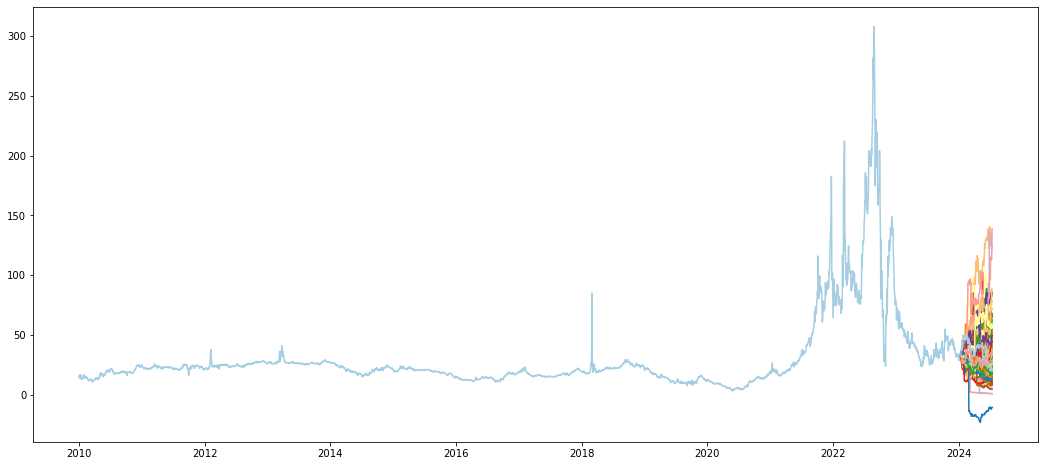

In [330]:
nbEchantillon = 130
ancData = dataPrices['Day-ahead'][0:-1]
# print(startVal, startDate)
startVal = ancData[-1]
startDate = ancData.index[-1]
for i in tqdm(range(100)):
    val = startVal
    date = startDate
    simul = pd.Series([startVal],index=[startDate]);
    for i in range(nbEchantillon):
        val = (1 + getRandomValue(distribution,'cumul','freq','val')/100) * val;
        date = date + BusinessDay(1)
        simul[date] = val
    ancData = pd.concat([ancData,simul],axis=1)
fig = plt.figure(figsize=(18,8))
palette = sns.color_palette("Paired")
sns.set_palette(palette=palette)
plt.plot(ancData);

31.675096651653647 55.984318015046796


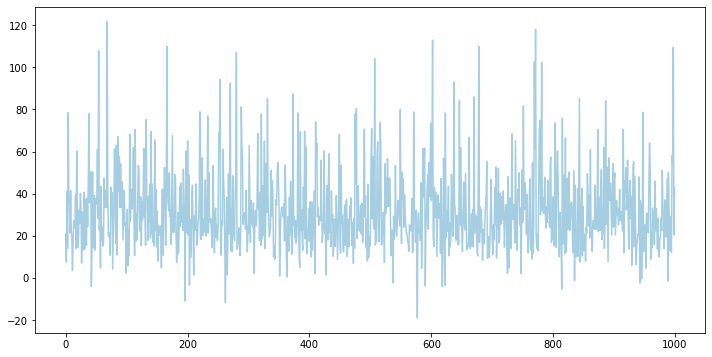

In [261]:
end = ancData.index[-1]
# val = ancData.loc[startDate+BusinessDay(10)].values
val = ancData.loc[end].values
# val[~np.isnan(val)]
val = val[1:]
fig = plt.figure(figsize=(12,6))
plt.plot(val);
print(val.mean(), np.percentile(val,90))

In [51]:
# fig, ax = plt.subplots(figsize=(18,8))
# sns.lineplot(ancData);
#ax2 = plt.twinx()
#sns.lineplot(data=final['€/$'], ax=ax2 , color='grey')